In [ ]:
#Adapted from the algorithm of Wang et al paper "Unsupervised Representation Learning by Predicting Random Distances” https://arxiv.org/abs/1912.12186
#from code base found at https://github.com/billhhh/RDP/
"""
Author: Bill Wang
"""

'\nAuthor: Bill Wang\n'

In [1]:
# make two local directories  one named save_model, one named logs
import os
os.mkdir('./save_model')
os.mkdir('./logs')

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install -q torch==1.10.0 torchvision

In [4]:
"""
Author: Bill Wang
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn.utils.random import sample_without_replacement
from sklearn.neighbors import KDTree
import copy


MAX_GRAD_NORM = 0.1  # clip gradient
LR_GAMMA = 0.1
LR_DECAY_EPOCHS = 5000
cos_activation = False

# the init method switch only controls RN
init_method = 'kaiming'
# init_method = 'rn_orthogonal'
# init_method = 'rn_uniform'
# init_method = 'rn_normal'

MAX_INT = np.iinfo(np.int32).max
MAX_FLOAT = np.finfo(np.float32).max


class RTargetNet(nn.Module):
    def __init__(self, in_c, out_c):
        super(RTargetNet, self).__init__()
        # architecture def
        c = in_c
        layers = []

        for h in [out_c]:
            layers.append(nn.Linear(c, h))
            if not cos_activation and init_method != 'rn_orthogonal':
                layers.append(nn.LeakyReLU(inplace=True, negative_slope=2.5e-1))
            c = h

        self.layers = nn.Sequential(*layers)

        # init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if cos_activation:
                    stdv = 1. / math.sqrt(m.weight.size(1))
                    m.weight.data.normal_(std=stdv)
                    if m.bias is not None:
                        # m.bias.data.normal_(std=stdv)
                        m.bias.data.uniform_(0, math.pi)
                elif init_method == 'kaiming':
                    nn.init.kaiming_normal_(m.weight)
                    nn.init.constant_(m.bias, 0.0)
                elif init_method == 'rn_orthogonal':
                    nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                    nn.init.constant_(m.bias, 0.0)
                elif init_method == 'rn_uniform':
                    stdv = 1. / math.sqrt(m.weight.size(1))
                    m.weight.data.uniform_(-stdv, stdv)
                    if m.bias is not None:
                        m.bias.data.uniform_(-stdv, stdv)
                elif init_method == 'rn_normal':
                    stdv = 1. / math.sqrt(m.weight.size(1))
                    m.weight.data.normal_(std=stdv)
                    if m.bias is not None:
                        m.bias.data.normal_(std=stdv)
                else:
                    raise ValueError('could not find init_method %s' % init_method)

    def forward(self, x):
        x = self.layers(x)
        if cos_activation:
            x = torch.cos(x)
        return x


class RNet(nn.Module):
    def __init__(self, in_c, out_c, dropout_r):
        super(RNet, self).__init__()

        # architecture def
        c = in_c
        layers = []

        for h in [out_c]:
            layers.append(nn.Linear(c, h))
            # if not cos_activation:
            if True:
                layers.append(nn.LeakyReLU(negative_slope=2e-1, inplace=True))
            layers.append(nn.Dropout(dropout_r))
            c = h

        self.layers = nn.Sequential(*layers)

        # one more layer than target network for enough capacity
        self.fc2 = nn.Linear(out_c, out_c)

        # init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if True:
                    nn.init.kaiming_normal_(m.weight)
                    nn.init.constant_(m.bias, 0.0)
                else:
                    stdv = 1. / math.sqrt(m.weight.size(1))
                    # m.weight.data.uniform_(-stdv, stdv)
                    m.weight.data.normal_(std=stdv)
                    if m.bias is not None:
                        # m.bias.data.uniform_(-stdv, stdv)
                        m.bias.data.normal_(std=stdv)

    def forward(self, x):
        x = self.layers(x)
        # if cos_activation:
        if False:
            x = torch.cos(x)
        return x


class RDP_Model:
    def __init__(self, in_c, out_c, logfile=None, USE_GPU=False, LR=1e-4, dropout_r=0.2):
        self.r_target_net = RTargetNet(in_c, out_c)
        self.r_net = RNet(in_c, out_c, dropout_r)
        self.USE_GPU = USE_GPU
        self.LR = LR
        self.logfile = logfile

        print(self.r_target_net)
        if self.logfile:
            self.logfile.write(str(self.r_target_net))
        print(self.r_net)
        if self.logfile:
            self.logfile.write(str(self.r_net))

        if USE_GPU:
            self.r_target_net = self.r_target_net.cuda()
            self.r_net = self.r_net.cuda()

        # define optimizer for predict network
        # self.r_net_optim = torch.optim.Adam(self.r_net.parameters(), lr=LR)
        self.r_net_optim = torch.optim.SGD(self.r_net.parameters(), lr=LR, momentum=0.9)

        self.epoch = 0

    def train_model(self, x, epoch):
        self.r_net.train()

        x_random = copy.deepcopy(x)
        np.random.shuffle(x_random)
        x_random = torch.FloatTensor(x_random)
        if self.USE_GPU:
            x_random = x_random.cuda()

        x = torch.FloatTensor(x)

        if self.USE_GPU:
            x = x.cuda()

        if epoch % LR_DECAY_EPOCHS == 0 and self.epoch != epoch:
            self.adjust_learning_rate()
            self.epoch = epoch

        r_target = self.r_target_net(x).detach()
        r_pred = self.r_net(x)
        gap_loss = torch.mean(F.mse_loss(r_pred, r_target, reduction='none'), dim=1).mean()

        r_target_random = self.r_target_net(x_random).detach()
        r_pred_random = self.r_net(x_random)

        xy = (F.normalize(r_target, p=1, dim=1) * F.normalize(r_target_random, p=1, dim=1)).sum(dim=1)
        x_y_ = (F.normalize(r_pred, p=1, dim=1) * F.normalize(r_pred_random, p=1, dim=1)).sum(dim=1)
        pair_wise_loss = F.mse_loss(xy, x_y_)

        loss = gap_loss + pair_wise_loss

        self.r_net_optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.r_net.parameters(), MAX_GRAD_NORM)
        self.r_net_optim.step()
        return gap_loss.data.cpu().numpy()

    def eval_model(self, x):
        self.r_net.eval()
        x_random = copy.deepcopy(x)
        np.random.shuffle(x_random)

        x = torch.FloatTensor(x)
        x_random = torch.FloatTensor(x_random)

        if self.USE_GPU:
            x = x.cuda()
            x_random = x_random.cuda()

        r_target = self.r_target_net(x)
        r_pred = self.r_net(x)
        gap_loss = torch.mean(F.mse_loss(r_pred, r_target, reduction='none'), dim=1)

        r_target_random = self.r_target_net(x_random).detach()
        r_pred_random = self.r_net(x_random)

        xy = F.normalize(r_target, p=1, dim=1) * F.normalize(r_target_random, p=1, dim=1)
        x_y_ = F.normalize(r_pred, p=1, dim=1) * F.normalize(r_pred_random, p=1, dim=1)
        pair_wise_loss = torch.mean(F.mse_loss(xy, x_y_, reduction='none'), dim=1)
        scores = gap_loss + pair_wise_loss
        return scores.data.cpu().numpy()

    def eval_model_lesinn(self, x):
        self.r_net.eval()
        x = torch.FloatTensor(x)

        if self.USE_GPU:
            x = x.cuda()

        r_pred = self.r_net(x)
        scores = self.lesinn(r_pred.data.cpu().numpy())
        return scores.squeeze()

    def lesinn(self, x_train):
        rng = np.random.RandomState(42)
        ensemble_size = 50
        subsample_size = 8
        scores = np.zeros([x_train.shape[0], 1])
        # for reproductibility purpose
        seeds = rng.randint(MAX_INT, size=ensemble_size)
        for i in range(0, ensemble_size):
            rs = np.random.RandomState(seeds[i])
            #        sid = np.random.choice(x_train.shape[0], subsample_size)
            sid = sample_without_replacement(n_population=x_train.shape[0], n_samples=subsample_size, random_state=rs)
            subsample = x_train[sid]
            kdt = KDTree(subsample, metric='euclidean')
            dists, indices = kdt.query(x_train, k=1)
            scores += dists
        scores = scores / ensemble_size
        return scores

    def adjust_learning_rate(self):
        self.LR *= LR_GAMMA
        print(' * adjust C_LR == {}'.format(self.LR))
        if self.logfile:
            self.logfile.write(' * adjust C_LR == {}\n'.format(self.LR))

        for param_group in self.r_net_optim.param_groups:
            param_group['lr'] = self.LR

    def save_model(self, path):
        dict_to_save = {
            'r_net': self.r_net.state_dict(),
            'r_target_net': self.r_target_net.state_dict(),
            # 'r_net_optim': self.r_net_optim,
            # 'LR': self.LR,
        }
        torch.save(dict_to_save, path)

    def load_model(self, name):
        states = torch.load(name)
        self.r_net.load_state_dict(states['r_net'])
        self.r_target_net.load_state_dict(states['r_target_net'])
        if 'r_net_optim' in states:
            self.r_net_optim = states['r_net_optim']
        if 'LR' in states:
            self.LR = states['LR']


In [5]:
import pandas as pd
import random

from sklearn.datasets import load_svmlight_file
from sklearn.metrics import average_precision_score, roc_auc_score

import time
import datetime



def dataLoading(path, logfile=None):

    # loading data
    df = pd.read_csv(path)
    labels = df['class']
    x_df = df.drop(['class'], axis=1)
    x = x_df.values
    print("Data shape: (%d, %d)" % x.shape)
    if logfile:
        logfile.write("Data shape: (%d, %d)\n" % x.shape)

    return x, labels


# random sampling with replacement
def random_list(start, stop, length):
    if length >= 0:
        length = int(length)
    start, stop = (int(start), int(stop)) if start <= stop else (int(stop), int(start))
    random_list = []
    for i in range(length):
        random_list.append(random.randint(start, stop))  # including start and stop
    return random_list


def writeResults(path, name, roc_auc, average_precision_score ):    
    csv_file = open(path, 'a') 
    row = name + "," + str(roc_auc)+ ","  + str(average_precision_score) +"\n"
    csv_file.write(row)

def aucPerformance(scores, labels, output, dataset_name, logfile=None):
    roc_auc = roc_auc_score(labels, scores)
#    print(roc_auc)
    ap = average_precision_score(labels, scores)
    print("AUC-ROC: %.4f, AUC-PR: %.4f" % (roc_auc, ap))
    writeResults(output, dataset_name, roc_auc, ap)

    if logfile:
        logfile.write("AUC-ROC: %.4f, AUC-PR: %.4f\n" % (roc_auc, ap))

#    plt.title('Receiver Operating Characteristic')
#    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
#    plt.legend(loc='lower right')
#    plt.plot([0,1],[0,1],'r--')
#    plt.xlim([-0.001, 1])
#    plt.ylim([0, 1.001])
#    plt.ylabel('True Positive Rate')
#    plt.xlabel('False Positive Rate')
#    plt.show();

    return roc_auc, ap


def tic_time():
    print("=====================================================")
    tic_datetime = datetime.datetime.now()
    print("tic_datetime:", tic_datetime)
    print("tic_datetime.strftime:", tic_datetime.strftime('%Y-%m-%d %H:%M:%S.%f'))
    tic_walltime = time.time()
    print("tic_walltime:", tic_walltime)
    tic_cpu = time.clock()
    print("tic_cpu:", tic_cpu)
    print("=====================================================\n")


In [6]:


#from model import RDP_Model  #running in notebook
import numpy as np
import random
import os
#from util import random_list, aucPerformance #running in notebook

is_batch_replace = True
is_eval = False
test_1l_only = True


class RDPTree():
    def __init__(self,
                 t_id,
                 tree_depth,
                 filter_ratio=0.1):

        self.t_id = t_id
        self.tree_depth = tree_depth
        self.filter_ratio = filter_ratio
        self.thresh = []

    # include train and eval
    def training_process(self,
                         x,
                         labels,
                         batch_size,
                         node_batch,
                         node_epoch,
                         eval_interval,
                         out_c,
                         USE_GPU,
                         LR,
                         save_path,
                         logfile=None,
                         dropout_r=0.1,
                         svm_flag=False,
                         ):
        if svm_flag:
            x_ori = x.toarray()
        else:
            x_ori = x
        labels_ori = labels
        x_level = np.zeros(x_ori.shape[0])
        for level in range(1, self.tree_depth+1):

            # form x and labels
            keep_pos = np.where(x_level == 0)
            x = x_ori[keep_pos]
            labels = labels_ori[keep_pos]
            group_num = int(x.shape[0] / batch_size) + 1
            batch_x = np.array_split(x, group_num)
            model = RDP_Model(in_c=x.shape[1], out_c=out_c, USE_GPU=USE_GPU,
                            LR=LR, logfile=logfile, dropout_r=dropout_r)
            best_auc = best_epoch = 0

            for epoch in range(0, node_epoch):
                if not is_batch_replace:
                    random.shuffle(batch_x)
                    batch_cnt = 0
                    for batch_i in batch_x:
                        gap_loss = model.train_model(batch_i, epoch)
                        # print("epoch ", epoch, "loss: ", loss)
                        batch_cnt += 1
                        if batch_cnt >= node_batch:
                            break

                else:
                    # random sampling with replacement
                    for batch_i in range(node_batch):
                        random_pos = random_list(0, x.shape[0] - 1, batch_size)
                        batch_data = x[random_pos]
                        gap_loss = model.train_model(batch_data, epoch)

                if epoch % eval_interval == 0:
                    # print("epoch ", epoch, "gap_loss:", gap_loss, " recon_loss:", recon_loss)
                    # if logfile:
                    #     logfile.write("epoch " + str(epoch) + " gap_loss: " + str(gap_loss) +
                    #                   " recon_loss: " + str(recon_loss) + '\n')

                    print("tree_id:", self.t_id, "level:", level)
                    print("keep_pos.size ==", keep_pos[0].size)
                    if logfile:
                        logfile.write("tree_id: " + str(self.t_id) + " level: " + str(level)
                                      + "keep_pos.size == " + str(keep_pos[0].size) + '\n')
                    print("epoch ", epoch, "gap_loss:", gap_loss)
                    if logfile:
                        logfile.write("epoch " + str(epoch) + " gap_loss: " + str(gap_loss) + '\n')
                    model.save_model(save_path + 't' + str(self.t_id) + '_l' + str(level) + '_latest.h5')

                    scores = model.eval_model(x)

                    # eval
                    if is_eval:
                        try:
                            roc_auc, ap = aucPerformance(scores, labels, logfile)
                            if roc_auc > best_auc:
                                best_auc = roc_auc
                                best_epoch = epoch

                            print("Best AUC-ROC: %.4f" % best_auc)
                            if logfile:
                                logfile.write("Best AUC-ROC: %.4f\n" % best_auc)
                            print("Best Epoch %d\n" % best_epoch)
                            if logfile:
                                logfile.write("Best Epoch %d\n\n" % best_epoch)
                        except ValueError:
                            print("Only one class present in y_true. ROC AUC score is not defined in that case.")

                    if logfile:
                        logfile.flush()

            # filter anomaly elements. the higher the scores are, the more abnormal
            ranking_scores = scores
            score_ranking_idx = np.argsort(ranking_scores)
            filter_num = int(self.filter_ratio * score_ranking_idx.size)
            filter_idx = score_ranking_idx[score_ranking_idx.size-filter_num:]
            x_level[keep_pos[0][filter_idx]] = self.tree_depth+1 - level
            self.thresh.append(ranking_scores[score_ranking_idx[score_ranking_idx.size-filter_num]])

            # epoch for
        # level for

        # save self.thresh
        filename = save_path + 'threshList_t' + str(self.t_id) + '.txt'
        list_save(self.thresh, filename, 'w')

    def testing_process(self,
                        x,
                        out_c,
                        USE_GPU,
                        load_path,
                        dropout_r,
                        testing_method='last_layer',
                        svm_flag=False,
                        ):

        if svm_flag:
            x_ori = x.toarray()
        else:
            x_ori = x
        x_level = np.zeros(x_ori.shape[0])
        self.thresh = list_read(load_path + 'threshList_t' + str(self.t_id) + '.txt')
        for level in range(1, self.tree_depth + 1):
            # form x
            keep_pos = np.where(x_level == 0)
            x = x_ori[keep_pos]
            model = RDP_Model(in_c=x.shape[1], out_c=out_c, USE_GPU=USE_GPU,
                            dropout_r=dropout_r)
            
            if testing_method == 'last_layer':
                # high --> low load
                model.load_model(
                    load_path + 't' + str(self.t_id) + '_l' + str(self.tree_depth + 1 - level) + '_latest.h5')
            else:
                # low --> high load
                model.load_model(load_path + 't' + str(self.t_id) + '_l' + str(level) + '_latest.h5')

            # eval
            scores = model.eval_model(x)

            if level == 1:
                first_level_scores = scores
                if test_1l_only and testing_method != 'level':
                    return x_level, first_level_scores
            # filter elements
            if testing_method == 'last_layer':
                filter_idx = np.where(scores >= float(self.thresh[self.tree_depth + 1 - level - 1]))
            else:
                filter_idx = np.where(scores >= float(self.thresh[level-1]))
            x_level[keep_pos[0][filter_idx]] = self.tree_depth+1 - level

        return x_level, first_level_scores


def list_save(content, filename, mode='a'):
    # Try to save a list variable in txt file.
    file = open(filename, mode)
    for i in range(len(content)):
        file.write(str(content[i])+'\n')
    file.close()


def list_read(filename):
    # Try to read a txt file and return a list. Return [] if there was a mistake.
    try:
        file = open(filename, 'r')
    except IOError:
        error = []
        return error
    content = file.readlines()

    for i in range(len(content)):
        content[i] = content[i][:len(content[i]) - 1]

    file.close()
    return content


In [7]:
# this the cell equivalent to train.py
import datetime
import platform
#from rdp_tree import RDPTree  #running in notebook
import shutil
import os
import sys
#from util import dataLoading, random_list, tic_time  #running in notebook
import time
import torch





def train():
    global random_size

    shutil.rmtree(save_path)
    os.mkdir(save_path)

    svm_flag = False
    if 'svm' in data_path:
        svm_flag = True
        from util import get_data_from_svmlight_file
        x_ori, labels_ori = get_data_from_svmlight_file(data_path)
        random_size = 1024
    else:
        x_ori, labels_ori = dataLoading(data_path, logfile)
    data_size = labels_ori.size

    # build forest
    forest = []
    for i in range(forest_Tnum):
        forest.append(RDPTree(t_id=i+1,
                              tree_depth=tree_depth,
                              filter_ratio=filter_ratio,
                              ))

    print("Init tic time.")
    tic_time()

    # training process
    for i in range(forest_Tnum):

        # random sampling with replacement
        random_pos = random_list(0, data_size-1, random_size)
        # random sampling without replacement
        # random_pos = random.sample(range(0, data_size), random_size)

        # to form x and labels
        x = x_ori[random_pos]
        if svm_flag:
            labels = labels_ori[random_pos]
        else:
            labels = labels_ori[random_pos].values

        print("tree id:", i, "tic time.")
        tic_time()

        forest[i].training_process(
            x=x,
            labels=labels,
            batch_size=batch_size,
            node_batch=node_batch,
            node_epoch=node_epoch,
            eval_interval=eval_interval,
            out_c=out_c,
            USE_GPU=USE_GPU,
            LR=LR,
            save_path=save_path,
            logfile=logfile,
            dropout_r=dropout_r,
            svm_flag=svm_flag,
        )

        print("tree id:", i, "tic time end.")
        tic_time()



In [8]:
# this cell is equivalent to test.py
"""
Author: Bill Wang
"""

import datetime
import platform
import time

#from rdp_tree import RDPTree  # running in notebook
import numpy as np
import sys
#from util import dataLoading, aucPerformance, tic_time  #running in notebook
import torch
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt




def plotAUCPRCurve(y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    fig = plt.figure()
    plt.plot(recall, precision)
    fig.suptitle('RDP AUC-PR ', fontsize=20)
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=16)
    plt.show()

    # Data to plot precision - recall curve
    # PrecisionRecallDisplay.from_predictions(y_test, y_score)
    # RocCurveDisplay.from_predictions( y_test, y_score)
    fpr, tpr, thresholds=roc_curve(y_test, y_score)
    fig = plt.figure()
    plt.plot(fpr, tpr)
    fig.suptitle('RPD AUC-ROC ', fontsize=20)
    plt.xlabel('FPR', fontsize=18)
    plt.ylabel('TPR', fontsize=16)
    plt.show()

def test(output, dataset_name):
    svm_flag = False
    if 'svm' in data_path:
        svm_flag = True
        from util import get_data_from_svmlight_file
        x, labels = get_data_from_svmlight_file(data_path)
    else:
        x, labels = dataLoading(data_path)
    data_size = labels.size

    # build forest
    forest = []
    for i in range(forest_Tnum):
        forest.append(RDPTree(t_id=i+1,
                              tree_depth=tree_depth,
                              ))

    sum_result = np.zeros(data_size, dtype=np.float64)

    print("Init tic time.")
    tic_time()

    # testing process
    for i in range(forest_Tnum):

        print("tree id:", i, "tic time.")
        tic_time()

        x_level, first_level_scores = forest[i].testing_process(
            x=x,
            out_c=out_c,
            USE_GPU=USE_GPU,
            load_path=load_path,
            dropout_r=dropout_r,
            testing_method=testing_methods_set[testing_method - 1],
            svm_flag=svm_flag,
        )

        if testing_methods_set[testing_method - 1] == 'level':
            sum_result += x_level
        else:
            sum_result += first_level_scores

        print("tree id:", i, "tic time.")
        tic_time()

        if i==0:
            plotAUCPRCurve(labels, sum_result)  #y_test, y_score)
        else:
            plotAUCPRCurve(labels, sum_result/forest_Tnum)  # y_test, y_score)
    scores = sum_result / forest_Tnum
    aucPerformance(scores, labels, output, dataset_name)



In [ ]:
# this is the driver cell for RDP
# have all your data in your google drive in a folder called data
# to change the dataset you want to analyze change dataset

#dataset='annthyroid_21feat_normalised.csv'
root='gdrive/MyDrive/CSCI5523GroupAnomalyProject/data/'
#data_path = root+dataset
save_path = "save_model/"
log_path = "logs/log.log"
output='gdrive/MyDrive/CSCI5523GroupAnomalyProject/data/rdp_results.csv'

logfile = open(log_path, 'w')
node_batch = 30
node_epoch = 200  # epoch for a node training
eval_interval = 24
batch_size = 192
out_c = 50
USE_GPU = True
LR = 1e-1
tree_depth = 8
forest_Tnum = 30
filter_ratio = 0.05  # filter those with high anomaly scores
dropout_r = 0.1
random_size = 10000  # randomly choose 1024 size of data for training

if not torch.cuda.is_available():
    USE_GPU = False

# Set mode
dev_flag = True
if dev_flag:
    print("Running in DEV_MODE!")

load_path=save_path
out_c = 50

# count from 1
testing_methods_set = ['last_layer', 'first_layer', 'level']
testing_method = 1
USE_GPU = True
tree_depth = 8
forest_Tnum = 30
dropout_r = 0.1

if not torch.cuda.is_available():
    USE_GPU = False


mn_scales=[0.1, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]
#modified to fill in
#mn_scales=[0.1, 0.75, 1.25, 2.0]
mn_scales[1.0]
#cov_scales=[.5, 1, 1.1, 1.5]
cov_scales=[1]
#mn_scales=[1]
#cov_scales=[1]

for mn_scale in mn_scales:
    for cov_scale in cov_scales:
        inputfilename= 'cc_synthetic_cauchy_mn_scale_'+str(mn_scale)+'_cov_scale_'+str(cov_scale)+'.csv'
        dataset=inputfilename
        data_path=root+'CreditCardSyntheticCauchy/'+inputfilename
        print("for this run the data being analyzed is ", data_path)
        train()  #data_path gets passed as a previously set "global"
        test(output, dataset)  #data_path gets passed as a previously set "globl"

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# this is the driver cell for RDP
# have all your data in your google drive in a folder called data
# to change the dataset you want to analyze change dataset

#dataset='annthyroid_21feat_normalised.csv'
root='gdrive/MyDrive/data/'
#data_path = root+dataset
save_path = "save_model/"
log_path = "logs/log.log"
output='gdrive/MyDrive/data/rdp_results.csv'

logfile = open(log_path, 'w')
node_batch = 30
node_epoch = 200  # epoch for a node training
eval_interval = 24
batch_size = 192
out_c = 50
USE_GPU = True
LR = 1e-1
tree_depth = 8
forest_Tnum = 30
filter_ratio = 0.05  # filter those with high anomaly scores
dropout_r = 0.1
random_size = 10000  # randomly choose 1024 size of data for training

if not torch.cuda.is_available():
    USE_GPU = False

# Set mode
dev_flag = True
if dev_flag:
    print("Running in DEV_MODE!")

load_path=save_path
out_c = 50

# count from 1
testing_methods_set = ['last_layer', 'first_layer', 'level']
testing_method = 1
USE_GPU = True
tree_depth = 8
forest_Tnum = 30
dropout_r = 0.1

if not torch.cuda.is_available():
    USE_GPU = False



mn_scales=[.5, 1, 1.1, 1.5]
cov_scales=[.5, 1, 1.1, 1.5]
cov_scales=[1]
#cc_synthetic_heavytail_mn_scale_1_cov_scale_1.csv
for mn_scale in mn_scales:
    for cov_scale in cov_scales:
        filename= 'cc_synthetic_heavytail_mn_scale_'+str(mn_scale)+'_cov_scale_'+str(cov_scale)+'.csv'
        data_path=root+'CreditCardSyntheticStudentT/'+filename
        dataset=filename
        print("for this run the data being analyzed is ", data_path)
        train()  #data_path gets passed as a previously set "global"
        test(output, dataset)  #data_path gets passed as a previously set "globl"

Output hidden; open in https://colab.research.google.com to view.

Running in DEV_MODE!
for this run the data being analyzed is  gdrive/MyDrive/data/CreditCardSyntheticGaussian/creditcardfraud_normalised_mn_scaled_0.5.csv
Data shape: (284807, 29)
Init tic time.
tic_datetime: 2021-12-12 05:36:13.190429
tic_datetime.strftime: 2021-12-12 05:36:13.190429
tic_walltime: 1639287373.19194
tic_cpu: 15802.913166

tree id: 0 tic time.
tic_datetime: 2021-12-12 05:36:13.231569
tic_datetime.strftime: 2021-12-12 05:36:13.231569
tic_walltime: 1639287373.2324047
tic_cpu: 15802.953316

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)
tree_id: 1 level: 1
keep_pos.size == 10000
epoch  0 gap_loss: 0.075766824


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Streaming output truncated to the last 5000 lines.
keep_pos.size == 8146
epoch  96 gap_loss: 0.051899567
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  120 gap_loss: 0.039866474
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  144 gap_loss: 0.041030798
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  168 gap_loss: 0.045313135
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  192 gap_loss: 0.04865842
RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)
tree_id: 16 level: 6
keep_pos.size == 7739
epoch  0 gap_loss: 0.15212
tree_id: 16 level: 6
keep_pos.size == 7739
epoch  24 gap_loss: 0.047063585
tree_id: 16 level: 6
keep_pos.size == 7739


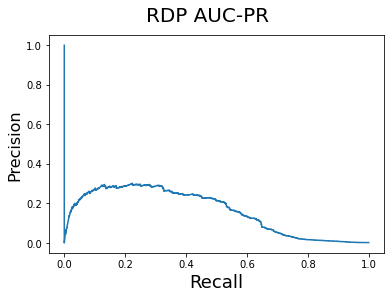

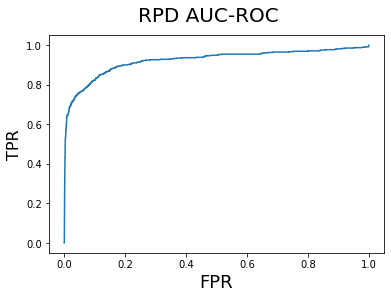

tree id: 1 tic time.
tic_datetime: 2021-12-12 06:41:24.883036
tic_datetime.strftime: 2021-12-12 06:41:24.883036
tic_walltime: 1639291284.883149
tic_cpu: 19715.330899

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 1 tic time.
tic_datetime: 2021-12-12 06:41:26.033276
tic_datetime.strftime: 2021-12-12 06:41:26.033276
tic_walltime: 1639291286.0340893
tic_cpu: 19716.480682



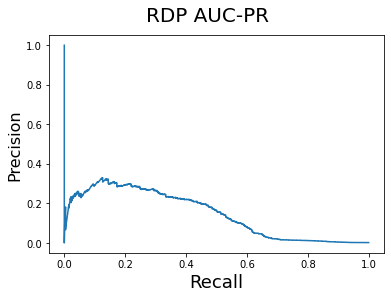

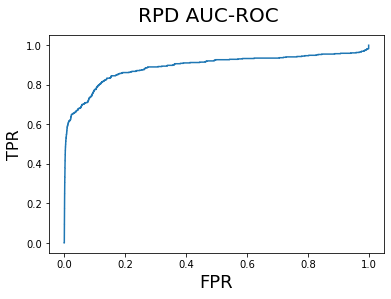

tree id: 2 tic time.
tic_datetime: 2021-12-12 06:41:26.517373
tic_datetime.strftime: 2021-12-12 06:41:26.517373
tic_walltime: 1639291286.5175164
tic_cpu: 19716.963793

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 2 tic time.
tic_datetime: 2021-12-12 06:41:27.695227
tic_datetime.strftime: 2021-12-12 06:41:27.695227
tic_walltime: 1639291287.6977313
tic_cpu: 19718.146631



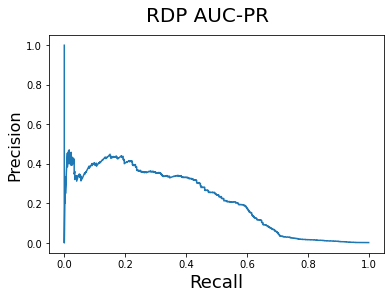

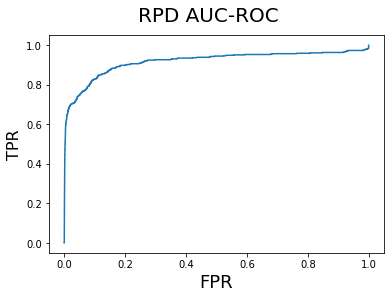

tree id: 3 tic time.
tic_datetime: 2021-12-12 06:41:28.175205
tic_datetime.strftime: 2021-12-12 06:41:28.175205
tic_walltime: 1639291288.1753392
tic_cpu: 19718.629665

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 3 tic time.
tic_datetime: 2021-12-12 06:41:29.341045
tic_datetime.strftime: 2021-12-12 06:41:29.341045
tic_walltime: 1639291289.3418515
tic_cpu: 19719.800571



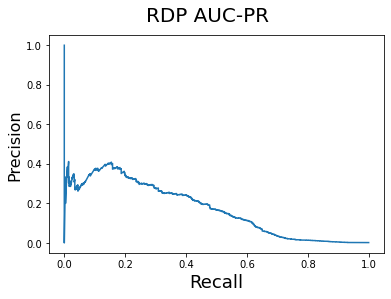

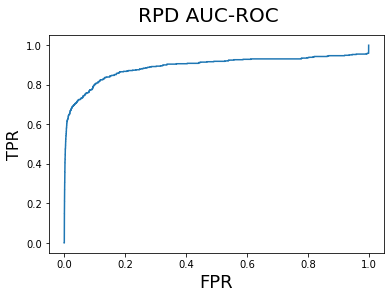

tree id: 4 tic time.
tic_datetime: 2021-12-12 06:41:29.819241
tic_datetime.strftime: 2021-12-12 06:41:29.819241
tic_walltime: 1639291289.8196023
tic_cpu: 19720.279993

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 4 tic time.
tic_datetime: 2021-12-12 06:41:30.990171
tic_datetime.strftime: 2021-12-12 06:41:30.990171
tic_walltime: 1639291290.9908147
tic_cpu: 19721.451517



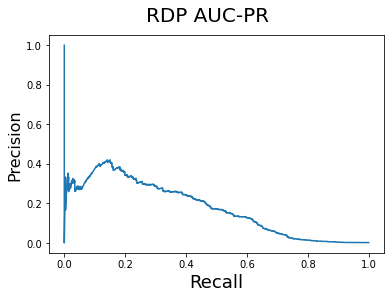

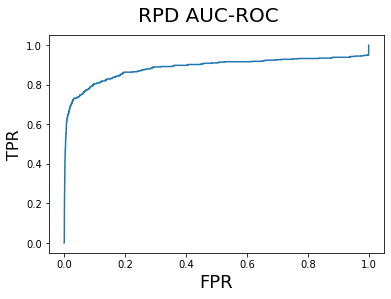

tree id: 5 tic time.
tic_datetime: 2021-12-12 06:41:31.530703
tic_datetime.strftime: 2021-12-12 06:41:31.530703
tic_walltime: 1639291291.5308616
tic_cpu: 19721.988787

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 5 tic time.
tic_datetime: 2021-12-12 06:41:32.718009
tic_datetime.strftime: 2021-12-12 06:41:32.718009
tic_walltime: 1639291292.718174
tic_cpu: 19723.18298



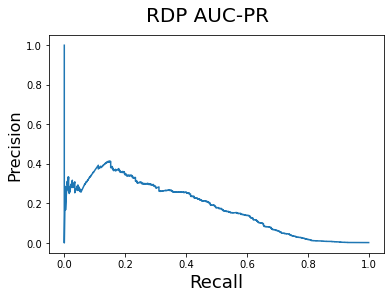

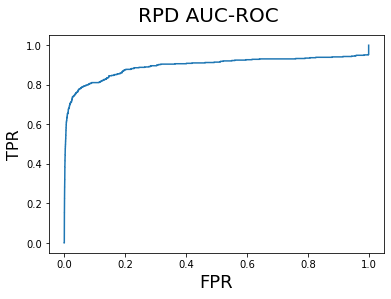

tree id: 6 tic time.
tic_datetime: 2021-12-12 06:41:33.270665
tic_datetime.strftime: 2021-12-12 06:41:33.270665
tic_walltime: 1639291293.2708182
tic_cpu: 19723.745645

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 6 tic time.
tic_datetime: 2021-12-12 06:41:34.461792
tic_datetime.strftime: 2021-12-12 06:41:34.461792
tic_walltime: 1639291294.4625776
tic_cpu: 19724.928895



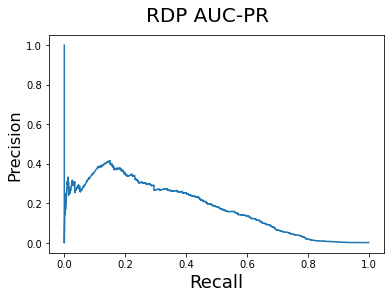

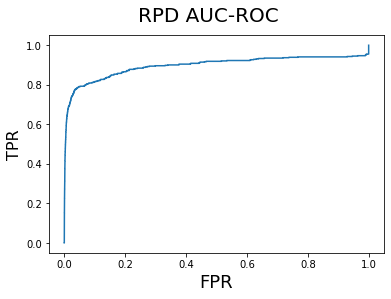

tree id: 7 tic time.
tic_datetime: 2021-12-12 06:41:34.973474
tic_datetime.strftime: 2021-12-12 06:41:34.973474
tic_walltime: 1639291294.9735844
tic_cpu: 19725.437143

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 7 tic time.
tic_datetime: 2021-12-12 06:41:36.154220
tic_datetime.strftime: 2021-12-12 06:41:36.154220
tic_walltime: 1639291296.1543467
tic_cpu: 19726.617138



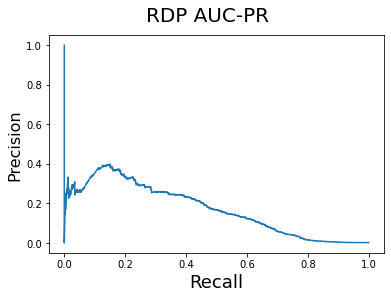

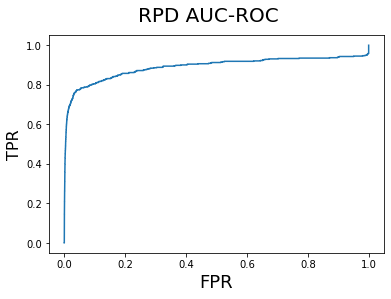

tree id: 8 tic time.
tic_datetime: 2021-12-12 06:41:36.724742
tic_datetime.strftime: 2021-12-12 06:41:36.724742
tic_walltime: 1639291296.7264695
tic_cpu: 19727.186476

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 8 tic time.
tic_datetime: 2021-12-12 06:41:37.912867
tic_datetime.strftime: 2021-12-12 06:41:37.912867
tic_walltime: 1639291297.9129922
tic_cpu: 19728.368282



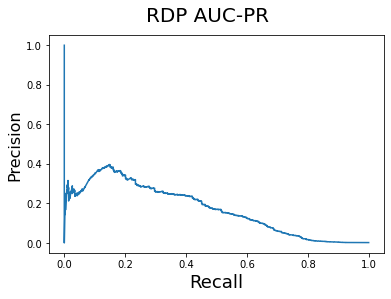

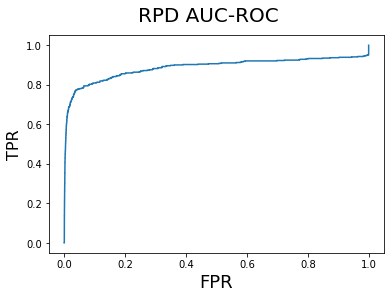

tree id: 9 tic time.
tic_datetime: 2021-12-12 06:41:38.660504
tic_datetime.strftime: 2021-12-12 06:41:38.660504
tic_walltime: 1639291298.6606576
tic_cpu: 19729.108454

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 9 tic time.
tic_datetime: 2021-12-12 06:41:39.847026
tic_datetime.strftime: 2021-12-12 06:41:39.847026
tic_walltime: 1639291299.8478286
tic_cpu: 19730.2943



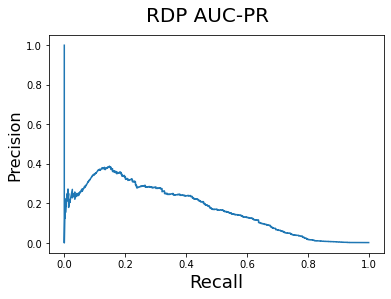

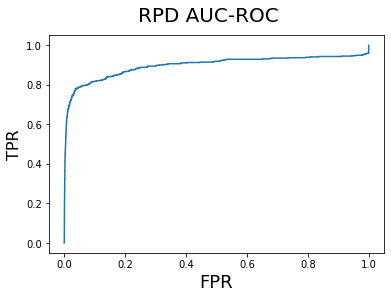

tree id: 10 tic time.
tic_datetime: 2021-12-12 06:41:40.315092
tic_datetime.strftime: 2021-12-12 06:41:40.315092
tic_walltime: 1639291300.315456
tic_cpu: 19730.754923

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 10 tic time.
tic_datetime: 2021-12-12 06:41:41.485069
tic_datetime.strftime: 2021-12-12 06:41:41.485069
tic_walltime: 1639291301.485872
tic_cpu: 19731.921156



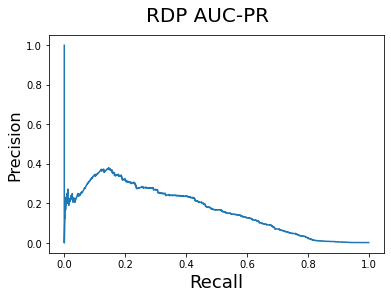

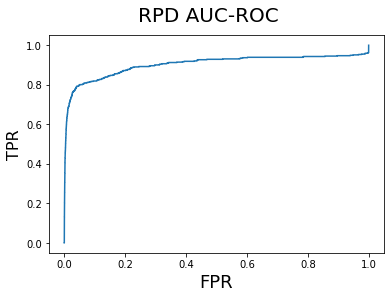

tree id: 11 tic time.
tic_datetime: 2021-12-12 06:41:41.979378
tic_datetime.strftime: 2021-12-12 06:41:41.979378
tic_walltime: 1639291301.9806535
tic_cpu: 19732.406951

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 11 tic time.
tic_datetime: 2021-12-12 06:41:43.153872
tic_datetime.strftime: 2021-12-12 06:41:43.153872
tic_walltime: 1639291303.1546578
tic_cpu: 19733.581433



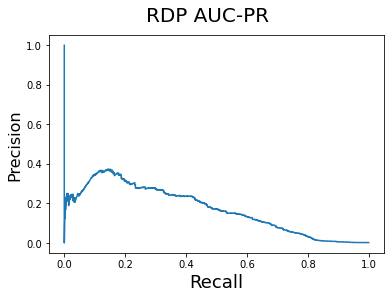

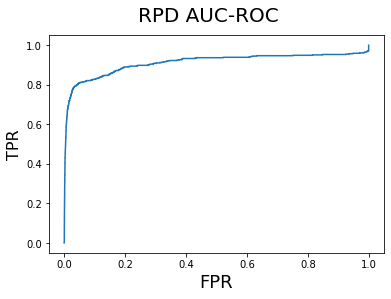

tree id: 12 tic time.
tic_datetime: 2021-12-12 06:41:43.644069
tic_datetime.strftime: 2021-12-12 06:41:43.644069
tic_walltime: 1639291303.6445851
tic_cpu: 19734.062238

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 12 tic time.
tic_datetime: 2021-12-12 06:41:44.811000
tic_datetime.strftime: 2021-12-12 06:41:44.811000
tic_walltime: 1639291304.8139648
tic_cpu: 19735.236433



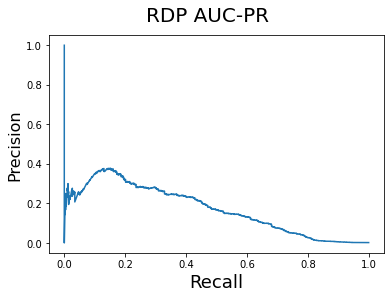

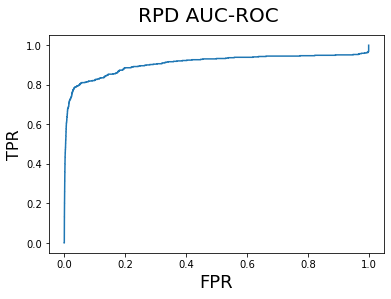

tree id: 13 tic time.
tic_datetime: 2021-12-12 06:41:45.308252
tic_datetime.strftime: 2021-12-12 06:41:45.308252
tic_walltime: 1639291305.3095865
tic_cpu: 19735.737656

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 13 tic time.
tic_datetime: 2021-12-12 06:41:46.493572
tic_datetime.strftime: 2021-12-12 06:41:46.493572
tic_walltime: 1639291306.494382
tic_cpu: 19736.914358



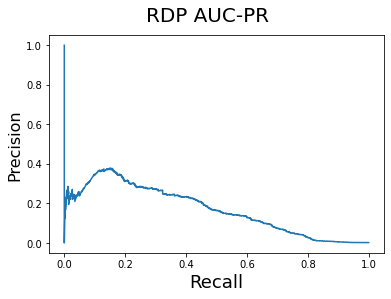

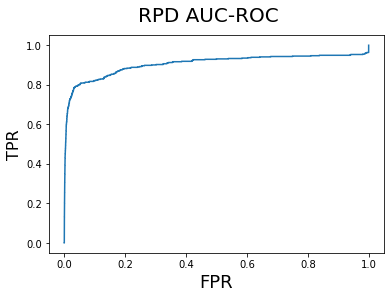

tree id: 14 tic time.
tic_datetime: 2021-12-12 06:41:46.957082
tic_datetime.strftime: 2021-12-12 06:41:46.957082
tic_walltime: 1639291306.958576
tic_cpu: 19737.380134

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 14 tic time.
tic_datetime: 2021-12-12 06:41:48.139004
tic_datetime.strftime: 2021-12-12 06:41:48.139004
tic_walltime: 1639291308.1397924
tic_cpu: 19738.56158



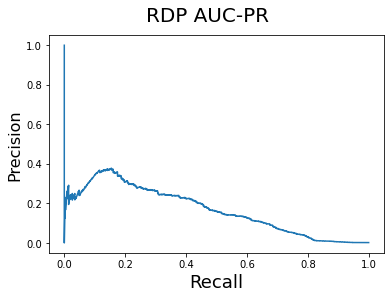

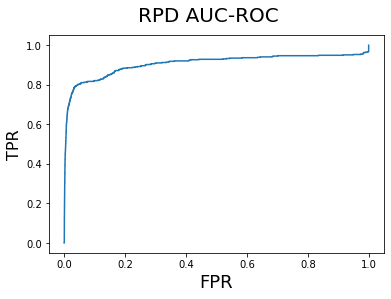

tree id: 15 tic time.
tic_datetime: 2021-12-12 06:41:48.616351
tic_datetime.strftime: 2021-12-12 06:41:48.616351
tic_walltime: 1639291308.617794
tic_cpu: 19739.041305

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 15 tic time.
tic_datetime: 2021-12-12 06:41:49.785526
tic_datetime.strftime: 2021-12-12 06:41:49.785526
tic_walltime: 1639291309.786931
tic_cpu: 19740.21366



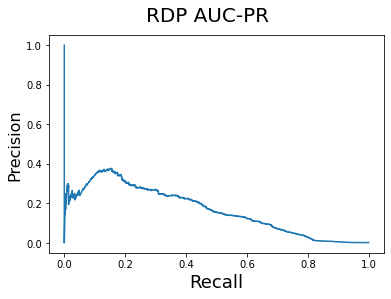

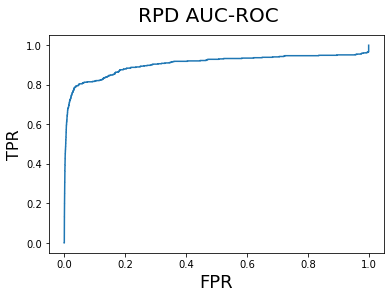

tree id: 16 tic time.
tic_datetime: 2021-12-12 06:41:50.307334
tic_datetime.strftime: 2021-12-12 06:41:50.307334
tic_walltime: 1639291310.3074565
tic_cpu: 19740.732318

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 16 tic time.
tic_datetime: 2021-12-12 06:41:51.492102
tic_datetime.strftime: 2021-12-12 06:41:51.492102
tic_walltime: 1639291311.493531
tic_cpu: 19741.914982



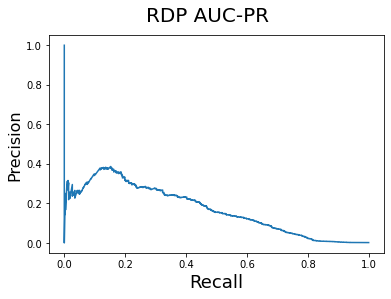

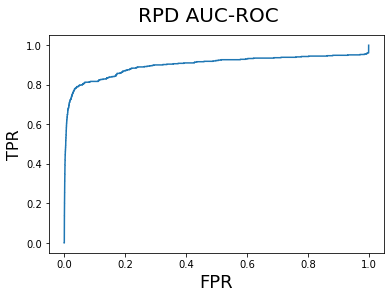

tree id: 17 tic time.
tic_datetime: 2021-12-12 06:41:52.050177
tic_datetime.strftime: 2021-12-12 06:41:52.050177
tic_walltime: 1639291312.0502882
tic_cpu: 19742.467525

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 17 tic time.
tic_datetime: 2021-12-12 06:41:53.249324
tic_datetime.strftime: 2021-12-12 06:41:53.249324
tic_walltime: 1639291313.2494855
tic_cpu: 19743.660786



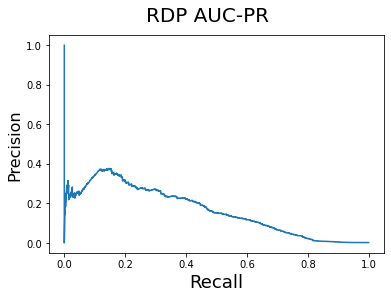

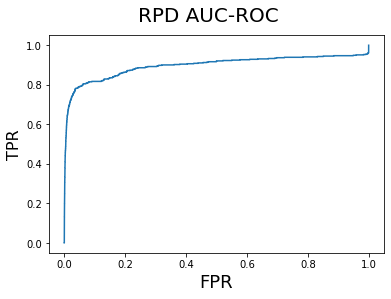

tree id: 18 tic time.
tic_datetime: 2021-12-12 06:41:53.998458
tic_datetime.strftime: 2021-12-12 06:41:53.998458
tic_walltime: 1639291313.998589
tic_cpu: 19744.411767

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 18 tic time.
tic_datetime: 2021-12-12 06:41:55.192975
tic_datetime.strftime: 2021-12-12 06:41:55.192975
tic_walltime: 1639291315.1931806
tic_cpu: 19745.601431



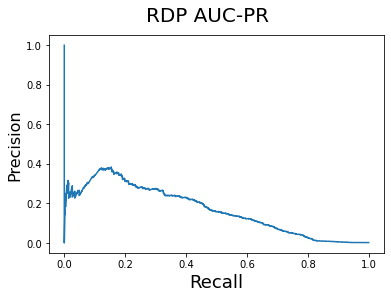

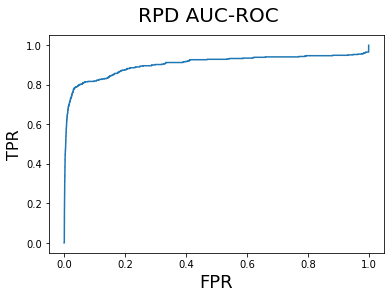

tree id: 19 tic time.
tic_datetime: 2021-12-12 06:41:55.681108
tic_datetime.strftime: 2021-12-12 06:41:55.681108
tic_walltime: 1639291315.6812534
tic_cpu: 19746.088847

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 19 tic time.
tic_datetime: 2021-12-12 06:41:56.866362
tic_datetime.strftime: 2021-12-12 06:41:56.866362
tic_walltime: 1639291316.8671381
tic_cpu: 19747.272118



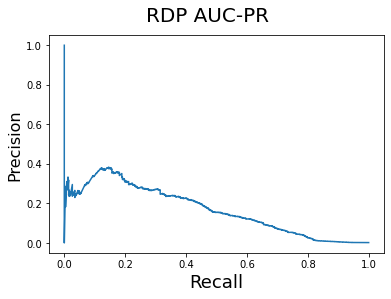

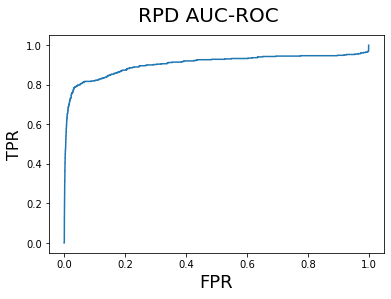

tree id: 20 tic time.
tic_datetime: 2021-12-12 06:41:57.339968
tic_datetime.strftime: 2021-12-12 06:41:57.339968
tic_walltime: 1639291317.3401127
tic_cpu: 19747.742504

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 20 tic time.
tic_datetime: 2021-12-12 06:41:58.514429
tic_datetime.strftime: 2021-12-12 06:41:58.514429
tic_walltime: 1639291318.5145986
tic_cpu: 19748.922657



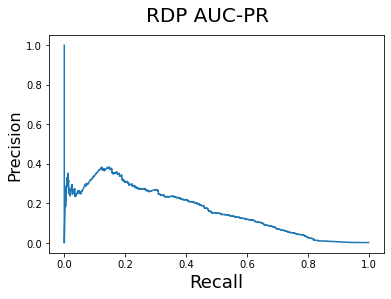

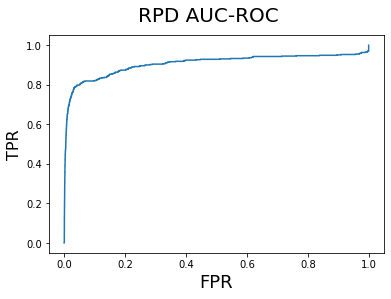

tree id: 21 tic time.
tic_datetime: 2021-12-12 06:41:58.984258
tic_datetime.strftime: 2021-12-12 06:41:58.984258
tic_walltime: 1639291318.9843833
tic_cpu: 19749.397951

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 21 tic time.
tic_datetime: 2021-12-12 06:42:00.165240
tic_datetime.strftime: 2021-12-12 06:42:00.165240
tic_walltime: 1639291320.1654015
tic_cpu: 19750.582567



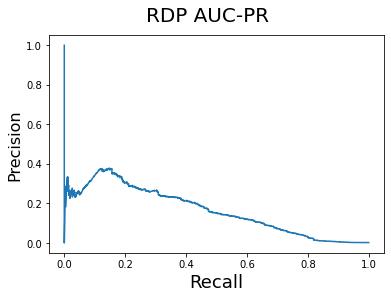

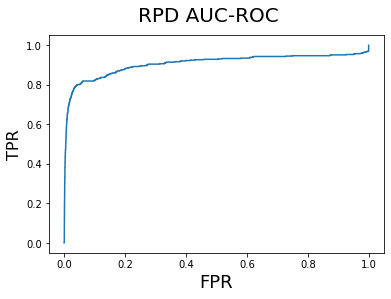

tree id: 22 tic time.
tic_datetime: 2021-12-12 06:42:00.651035
tic_datetime.strftime: 2021-12-12 06:42:00.651035
tic_walltime: 1639291320.651182
tic_cpu: 19751.074131

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 22 tic time.
tic_datetime: 2021-12-12 06:42:01.838853
tic_datetime.strftime: 2021-12-12 06:42:01.838853
tic_walltime: 1639291321.8390498
tic_cpu: 19752.268714



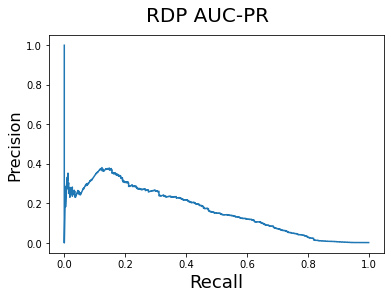

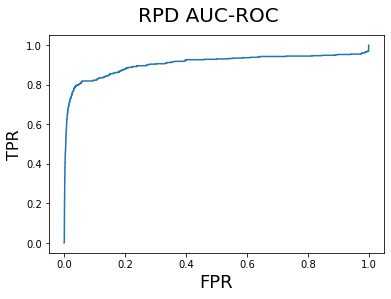

tree id: 23 tic time.
tic_datetime: 2021-12-12 06:42:02.339877
tic_datetime.strftime: 2021-12-12 06:42:02.339877
tic_walltime: 1639291322.3413696
tic_cpu: 19752.776401

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 23 tic time.
tic_datetime: 2021-12-12 06:42:03.533390
tic_datetime.strftime: 2021-12-12 06:42:03.533390
tic_walltime: 1639291323.5335555
tic_cpu: 19753.961347



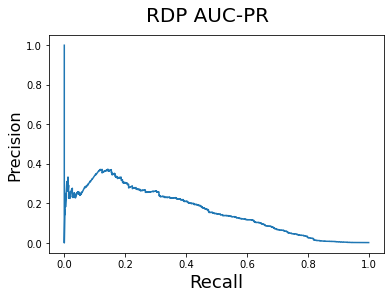

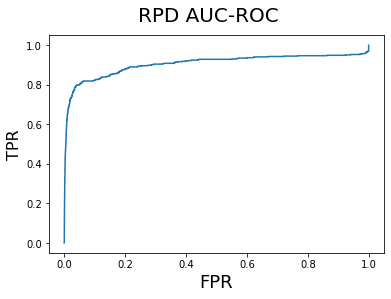

tree id: 24 tic time.
tic_datetime: 2021-12-12 06:42:04.019639
tic_datetime.strftime: 2021-12-12 06:42:04.019639
tic_walltime: 1639291324.0198004
tic_cpu: 19754.452824

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 24 tic time.
tic_datetime: 2021-12-12 06:42:05.215377
tic_datetime.strftime: 2021-12-12 06:42:05.215377
tic_walltime: 1639291325.2176118
tic_cpu: 19755.636397



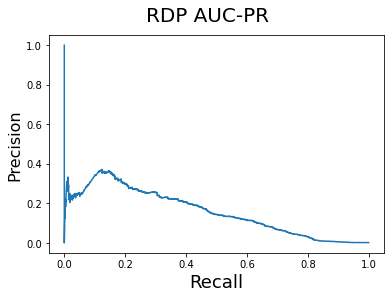

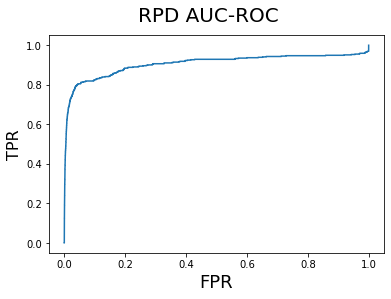

tree id: 25 tic time.
tic_datetime: 2021-12-12 06:42:05.754170
tic_datetime.strftime: 2021-12-12 06:42:05.754170
tic_walltime: 1639291325.7559347
tic_cpu: 19756.173711

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 25 tic time.
tic_datetime: 2021-12-12 06:42:06.930688
tic_datetime.strftime: 2021-12-12 06:42:06.930688
tic_walltime: 1639291326.930876
tic_cpu: 19757.3432



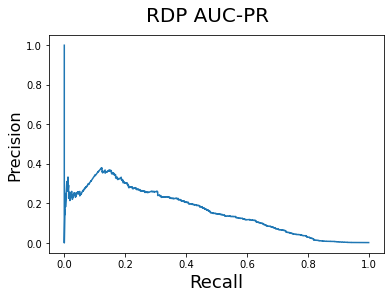

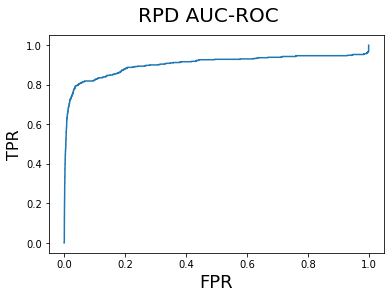

tree id: 26 tic time.
tic_datetime: 2021-12-12 06:42:07.488791
tic_datetime.strftime: 2021-12-12 06:42:07.488791
tic_walltime: 1639291327.4890118
tic_cpu: 19757.906306

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 26 tic time.
tic_datetime: 2021-12-12 06:42:08.690032
tic_datetime.strftime: 2021-12-12 06:42:08.690032
tic_walltime: 1639291328.690195
tic_cpu: 19759.096538



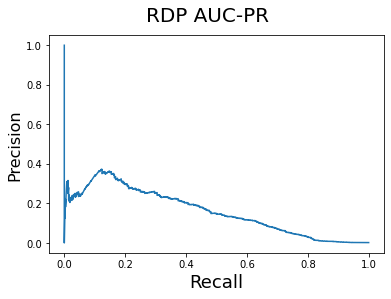

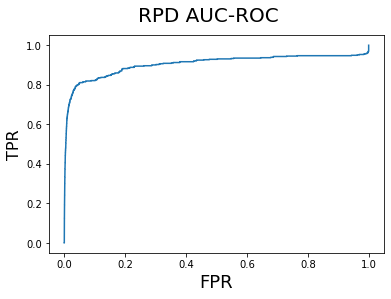

tree id: 27 tic time.
tic_datetime: 2021-12-12 06:42:09.401304
tic_datetime.strftime: 2021-12-12 06:42:09.401304
tic_walltime: 1639291329.4029493
tic_cpu: 19759.807379

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 27 tic time.
tic_datetime: 2021-12-12 06:42:10.566582
tic_datetime.strftime: 2021-12-12 06:42:10.566582
tic_walltime: 1639291330.5667787
tic_cpu: 19760.9747



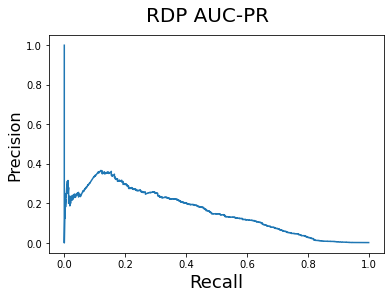

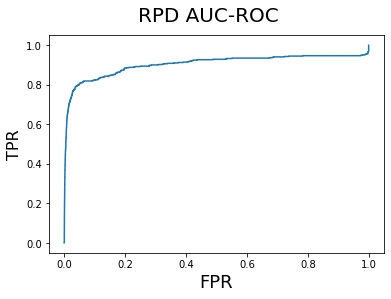

tree id: 28 tic time.
tic_datetime: 2021-12-12 06:42:11.064365
tic_datetime.strftime: 2021-12-12 06:42:11.064365
tic_walltime: 1639291331.0645132
tic_cpu: 19761.478339

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 28 tic time.
tic_datetime: 2021-12-12 06:42:12.244414
tic_datetime.strftime: 2021-12-12 06:42:12.244414
tic_walltime: 1639291332.245263
tic_cpu: 19762.665752



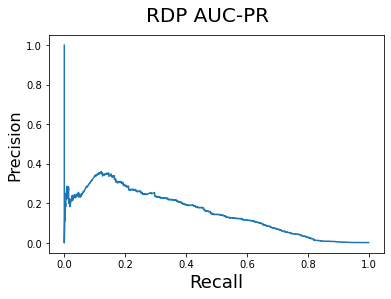

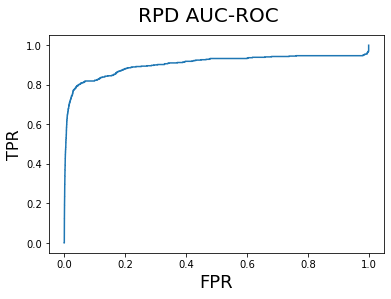

tree id: 29 tic time.
tic_datetime: 2021-12-12 06:42:12.754882
tic_datetime.strftime: 2021-12-12 06:42:12.754882
tic_walltime: 1639291332.7550378
tic_cpu: 19763.162059

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 29 tic time.
tic_datetime: 2021-12-12 06:42:13.941898
tic_datetime.strftime: 2021-12-12 06:42:13.941898
tic_walltime: 1639291333.9420695
tic_cpu: 19764.350176



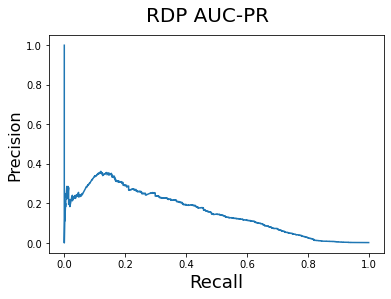

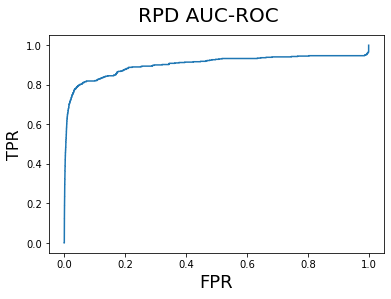

AUC-ROC: 0.9025, AUC-PR: 0.1534
for this run the data being analyzed is  gdrive/MyDrive/data/CreditCardSyntheticGaussian/creditcardfraud_normalised_mn_scaled_1.0.csv
Data shape: (284807, 29)
Init tic time.
tic_datetime: 2021-12-12 06:42:18.237765
tic_datetime.strftime: 2021-12-12 06:42:18.237765
tic_walltime: 1639291338.2386627
tic_cpu: 19766.263628

tree id: 0 tic time.
tic_datetime: 2021-12-12 06:42:18.267810
tic_datetime.strftime: 2021-12-12 06:42:18.267810
tic_walltime: 1639291338.2687008
tic_cpu: 19766.292996

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)
tree_id: 1 level: 1
keep_pos.size == 10000
epoch  0 gap_loss: 0.15806453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Streaming output truncated to the last 5000 lines.
epoch  24 gap_loss: 0.03062109
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  48 gap_loss: 0.028105466
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  72 gap_loss: 0.025614955
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  96 gap_loss: 0.033587083
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  120 gap_loss: 0.03179874
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  144 gap_loss: 0.02954532
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  168 gap_loss: 0.028605336
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  192 gap_loss: 0.028371653
RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, 

In [ ]:
# this is the driver cell for RDP
# have all your data in your google drive in a folder called data
# to change the dataset you want to analyze change dataset

#dataset='annthyroid_21feat_normalised.csv'
root='gdrive/MyDrive/data/'
#data_path = root+dataset
save_path = "save_model/"
log_path = "logs/log.log"
output='gdrive/MyDrive/data/rdp_results.csv'

logfile = open(log_path, 'w')
node_batch = 30
node_epoch = 200  # epoch for a node training
eval_interval = 24
batch_size = 192
out_c = 50
USE_GPU = True
LR = 1e-1
tree_depth = 8
forest_Tnum = 30
filter_ratio = 0.05  # filter those with high anomaly scores
dropout_r = 0.1
random_size = 10000  # randomly choose 1024 size of data for training

if not torch.cuda.is_available():
    USE_GPU = False

# Set mode
dev_flag = True
if dev_flag:
    print("Running in DEV_MODE!")

load_path=save_path
out_c = 50

# count from 1
testing_methods_set = ['last_layer', 'first_layer', 'level']
testing_method = 1
USE_GPU = True
tree_depth = 8
forest_Tnum = 30
dropout_r = 0.1

if not torch.cuda.is_available():
    USE_GPU = False

scales=[0.5, 1.0, 1.1, 1.5]
scales=[1.0]
for scale in scales:
    filename= 'creditcardfraud_normalised_mn_scaled_'+str(scale)+'.csv'
    data_path=root+'CreditCardSyntheticGaussian/'+filename
    dataset=filename
    print("for this run the data being analyzed is ", data_path)
    train()  #data_path gets passed as a previously set "global"
    test(output, dataset)  #data_path gets passed as a previously set "globl"
    